In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from src.env import *
from src.imports import *
from src.config import *
from src.dataset import *
from src.metric import *

Found cached dataset generator (C:/tempjeka/cache/huggingface/generator/default-f628ff2f2d994b84/0.0.0)
Loading cached split indices for dataset at C:\tempjeka\cache\huggingface\generator\default-f628ff2f2d994b84\0.0.0\cache-a84cfc0a0e11ed54.arrow and C:\tempjeka\cache\huggingface\generator\default-f628ff2f2d994b84\0.0.0\cache-665145fe0a5a6a51.arrow
Loading cached split indices for dataset at C:\tempjeka\cache\huggingface\generator\default-f628ff2f2d994b84\0.0.0\cache-e104a2bffe25c7fa.arrow and C:\tempjeka\cache\huggingface\generator\default-f628ff2f2d994b84\0.0.0\cache-4096519e2393e19f.arrow


<IPython.core.display.Javascript object>

In [3]:
enc_name = "microsoft/deberta-v3-base"
dec_name = "bert-base-multilingual-cased"
model_name = "bert2bert_collator"

<IPython.core.display.Javascript object>

In [4]:
enc_tokenizer = AutoTokenizer.from_pretrained(enc_name)
enc_tokenizer.bos_token = enc_tokenizer.cls_token
enc_tokenizer.eos_token = enc_tokenizer.sep_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
C:\tempjeka\anaconda3\lib\site-packages\transformers\convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<IPython.core.display.Javascript object>

In [5]:
dec_tokenizer = AutoTokenizer.from_pretrained(dec_name)
dec_tokenizer.bos_token = enc_tokenizer.cls_token
dec_tokenizer.eos_token = enc_tokenizer.sep_token

<IPython.core.display.Javascript object>

In [41]:
dataset = create_dataset(enc_tokenizer, dec_tokenizer).sort("input_ids_length")
# DataCollatorForSeq2Seq(enc_tokenizer)([dataset["train"][i] for i in range(0, 4)])

<IPython.core.display.Javascript object>

In [7]:
model = EncoderDecoderModel.from_encoder_decoder_pretrained(enc_name, dec_name)

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the m

<IPython.core.display.Javascript object>

In [8]:
model.config.decoder_start_token_id = dec_tokenizer.bos_token_id
model.config.pad_token_id = enc_tokenizer.pad_token_id

model.config.eos_token_id = dec_tokenizer.eos_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.decoder.bos_token_id = dec_tokenizer.bos_token_id

model.config.max_length = max_input_length
model.config.min_length = 10
model.config.no_repeat_ngram_size = 3
model.config.early_stopping = True
model.config.num_beams = 10

<IPython.core.display.Javascript object>

In [9]:
version = 1

<IPython.core.display.Javascript object>

In [10]:
version += 1
args = Seq2SeqTrainingArguments(
    output_dir=Path("models") / model_name,
    evaluation_strategy="steps",
    learning_rate=5e-5,
    #     lr_scheduler_type="constant_with_warmup",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=1,
    num_train_epochs=4,
    predict_with_generate=True,
    warmup_steps=3000,
    fp16=True,
    logging_dir=f"../made/logs/lightning_logs/{model_name}/{version}",
    logging_first_step=False,
    eval_steps=1000,
    logging_steps=500,
    overwrite_output_dir=True,
    group_by_length=True,
)

<IPython.core.display.Javascript object>

In [45]:
data_collator = DataCollatorForSeq2Seq(enc_tokenizer, model=model)

<IPython.core.display.Javascript object>

In [11]:
from transformers import DataCollatorWithPadding

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    compute_metrics=partial(compute_metrics, dec_tokenizer, metric),
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    data_collator=data_collator,
)

<IPython.core.display.Javascript object>

In [12]:
trainer.train()

C:\tempjeka\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
C:\tempjeka\anaconda3\lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need

Step,Training Loss,Validation Loss,Bleu,Gen Len
1000,3.055300,2.471047,0.038477,41.480000
2000,2.179300,2.005065,0.068839,52.240000
3000,1.976500,1.777953,0.069164,48.860000
4000,1.822400,1.622635,0.077683,73.920000
5000,1.653900,1.581295,0.066980,59.260000
6000,1.631200,1.460770,0.140961,77.800000
7000,1.547300,1.362556,0.178532,75.080000
8000,1.453900,1.288854,0.171196,82.080000
9000,1.401200,1.265296,0.173051,82.980000
10000,1.366900,1.189806,0.210562,77.900000


C:\tempjeka\anaconda3\lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
C:\tempjeka\anaconda3\lib\site-packages\transformers\generation\utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
C:\tempjeka\anaconda3\lib\site-packages\transformers\

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

C:\tempjeka\anaconda3\lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
C:\tempjeka\anaconda3\lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:634: FutureWarning: Version

In [13]:
model.save_pretrained(model_name)

<IPython.core.display.Javascript object>

In [7]:
model = EncoderDecoderModel.from_pretrained(model_name)

<IPython.core.display.Javascript object>

In [72]:
metric = evaluate.load("bleu")
model.cuda()
model.eval()
with torch.no_grad():
    dataset["test"].map(
        partial(
            compute_metrics_test,
            model,
            DataCollatorWithPadding(enc_tokenizer),
            dec_tokenizer,
            metric,
            log=False,
        ),
        batched=True,
        batch_size=batch_size,
    )

Map:   0%|          | 0/4950 [00:00<?, ? examples/s]

<IPython.core.display.Javascript object>

In [73]:
metric.compute()

{'bleu': 0.2914710978122671,
 'precisions': [0.548553857722158,
  0.3410333122375007,
  0.24195496639514355,
  0.1732859251308198],
 'brevity_penalty': 0.9794156064933341,
 'length_ratio': 0.9796245872959499,
 'translation_length': 74474,
 'reference_length': 76023}

<IPython.core.display.Javascript object>

In [43]:
metric = evaluate.load("bleu")
model.cuda()
model.eval()
_idx = 100
with torch.no_grad():
    dataset["test"].select(range(_idx, _idx + 10)).map(
        partial(compute_metrics_test, model, dec_tokenizer, metric, log=True),
        batched=True,
        batch_size=batch_size,
    )
metric.compute()

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

[{'input': 'It features free WiFi throughout.',
  'target': ['Гостям предоставляется бесплатный Wi-Fi.'],
  'preds': 'На всей территории предоставляется бесплатный Wi - Fi.'},
 {'input': 'The property offers free parking.',
  'target': ['На прилегающей территории обустроена бесплатная парковка.'],
  'preds': 'Предоставляется бесплатная парковка.'},
 {'input': 'Free WiFi is available throughout.',
  'target': ['Бесплатный Wi-Fi предоставляется на всей территории.'],
  'preds': 'На всей территории предоставляется бесплатный Wi - Fi.'},
 {'input': 'Free WiFi access is available.',
  'target': ['Предоставляется бесплатный Wi-Fi.'],
  'preds': 'Предоставляется бесплатный Wi - Fi.'}]

[{'input': 'Breakfast is served each morning.',
  'target': ['Каждое утро для гостей сервируется завтрак.'],
  'preds': 'По утрам для гостей сервируется завтрак.'},
 {'input': 'The property offers free parking.',
  'target': ['На территории дома для отпуска обустроена бесплатная парковка.'],
  'preds': 'Предоставляется бесплатная парковка.'},
 {'input': 'Some rooms include LCD TV.',
  'target': ['В некоторых номерах есть ЖК-телевизор.'],
  'preds': 'В некоторых номерах есть ЖК - телевизор.'},
 {'input': 'The bathrooms provide a hairdryer.',
  'target': ['В распоряжении гостей балкон и ванная комната с феном.'],
  'preds': 'В ванных комнатах предоставляется фен.'}]

[{'input': 'Free WiFi access is available.',
  'target': ['Гостям предоставляется бесплатный Wi-Fi.'],
  'preds': 'Предоставляется бесплатный Wi - Fi.'},
 {'input': 'A daily breakfast is included.',
  'target': ['Ежедневный завтрак включен в стоимость.'],
  'preds': 'Ежедневно сервируется завтрак.'}]

{'bleu': 0.2012768995288384,
 'precisions': [0.5079365079365079,
  0.2641509433962264,
  0.16279069767441862,
  0.09090909090909091],
 'brevity_penalty': 0.9534969548334766,
 'length_ratio': 0.9545454545454546,
 'translation_length': 63,
 'reference_length': 66}

<IPython.core.display.Javascript object>

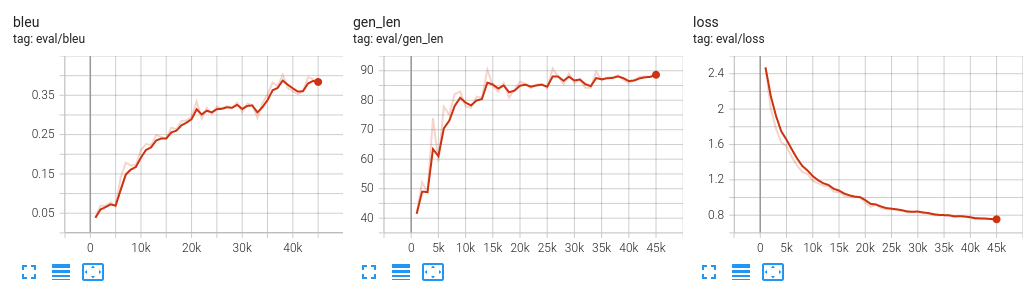 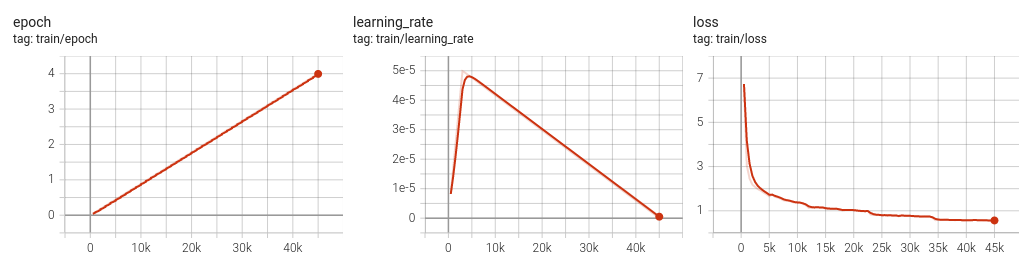